# Major Model Analysis Ahead

In [1]:
from utils.model_analysis_local import * 
import os
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
from PIL import Image
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

# Define Model, Subject and Image for Analysis

In [2]:
#Change as needed
checkpoint_path = '/Users/emilykruger/Documents/GitHub/aml_project_2023/hpc/utils/trained_models/alexnet_LR0.00015_SAMPLES_all_EPOCHS100_BATCHSIZE_64_TIME_2023-12-11_13:10:42.pt'
backbone = 'alexnet'
simple_head_state=True
#subject_id = 3
#image_id = 34

# Loading and (Pre-)Processing

In [ ]:
#load images and original activations 
brain, image_paths = load_subject_data(subject_id)

#pick image and activation
image = np.load(image_paths[image_id])
image = preprocess(image)
activation = torch.Tensor(brain[image_id,:])

In [ ]:
print(image_paths[image_id],'\n', image_paths[image_id-1])

In [ ]:
# import torch
# #import torchvision.models as models

# # Instantiate the model
# model = torch.load('/Users/emilykruger/Documents/GitHub/aml_project_2023/hpc/utils/pretrained_alexnet.pt')

# # Create a dummy input
# dummy_input = torch.randn(1, 3, 224, 224)

# # Pass the dummy input through the model up to the layer of interest
# layer_of_interest = 6  # Change this to the index of your layer of interest
# model = torch.nn.Sequential(*(list(model.features.children())[:layer_of_interest + 1]))
# output = model(dummy_input)
# output_shape = output.shape[1] * output.shape[2] * output.shape[3]

# # Print the output shape
# print(output.shape)

In [ ]:
output_size = 100

# Check if GPU is available and if not, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load in model & Create feature extractor
trained_model_state_dict = torch.load(checkpoint_path, map_location = device)
feature_extractor = torch.hub.load('utils', backbone, source = 'local')

trained_model = ResNet1HeadID(output_size = output_size, feature_extractor= feature_extractor,simple_head=simple_head_state).eval()
trained_model.load_state_dict(trained_model_state_dict["model_state_dict"])
trained_model_backbone = trained_model.feature_extractor

if backbone == "alexnet":
    output_layer_names = get_module_names(trained_model_backbone)[1:-1]
else:
    output_layer_names = get_block_names(trained_model_backbone)[:-1]

feature_extractor = create_feature_extractor(trained_model_backbone, output_layer_names)

#Extract features & predict fMRI data 
outputs = feature_extractor(image.unsqueeze(0))
flat_outputs = flatten_features(outputs)
predictions = make_prediction(trained_model, flat_outputs, trained_model.head.in_features)
print(predictions)

#Inverse transform of preds with frozen PCA models
pca = get_pca_model(subject_id)
inversed_predictions = predictions.copy()
for key in inversed_predictions:
    #convert prediction tensors to np arrays to make it compatible for inverse pca
    preds = inversed_predictions[key].detach().numpy()
    preds = torch.Tensor(pca.inverse_transform(preds))
    # inverse-pca and store in new dict
    inversed_predictions[key] = preds

# Model Analysis - Layers

## MNNPC Score

In [ ]:
scores = {}
##Caculating MNNPC (i.e. challenge metric) on Preds
for key in inversed_predictions:
    preds = inversed_predictions[key]
    mnnpc = MNNPC()
    score = mnnpc(pred = preds, gt=activation)
    scores[key] = score

print(scores)

## Looping over All Layers to Visualize Predicted Activations

In [ ]:
fig, axes = plt.subplots(nrows = 21, ncols =2)

In [ ]:
#show image
display(plt.imshow(image.permute(1,2,0)))

#plot predicted activation
for i, key in enumerate(inversed_predictions):
    for j, hem in enumerate(['left', 'right']):
        fsaverage_response_lh, fsaverage_response_rh = process_subject_data(inversed_predictions[key], 1)
        hemisphere = hem
        if hem == 'left':
            brain = fsaverage_response_lh
        else:
            brain = fsaverage_response_rh
        # Create the interactive brain surface map
        view = plotting.plot_surf_stat_map(
            surf_mesh=fsaverage['infl_'+hemisphere],
            stat_map= brain,
            bg_map=fsaverage['sulc_'+hemisphere],
            threshold=1e-14,
            cmap='cold_hot',
            colorbar=True,
            title=f'All vertices {hem} hemisphere. Layer: {key}',
            ax = axes[i][j],
            view = 'posterior'
        )
plt.show()

## Looping over all layers to visualize error

In [ ]:
#calculate absolute error
error_dict = inversed_predictions.copy()

for key in error_dict:
    error_dict[key] = abs(error_dict[key] - activation)

In [ ]:
display(plt.imshow(image.permute(1,2,0)))
views = []
for i, key in enumerate(error_dict):
    for j, hem in enumerate(['left', 'right']):
        fsaverage_response_lh, fsaverage_response_rh = process_subject_data(error_dict[key], 1)
        hemisphere = hem
        if hem == 'left':
            brain = fsaverage_response_lh
        else:
            brain = fsaverage_response_rh
        # Create the interactive brain surface map
        view = plotting.view_surf(
            surf_mesh=fsaverage['infl_'+hemisphere],
            surf_map= brain,
            bg_map=fsaverage['sulc_'+hemisphere],
            threshold=1e-14,
            cmap='hot',
            colorbar=True,
            title=f'{hem} hemisphere: {key}'
            #, view = 'posterior'
        )
        views.append(view)
#plt.show()

In [ ]:
for i in range(len(views)):
    display(views[i])

## Predicted vs. Actual Activation - Specific Layer

In [ ]:
#print all layer names
inversed_predictions.keys()

In [ ]:
###CHANGE INDEX HERE TO WHATEVER LAYER YOU WANT TO LOOK AT
layer = inversed_predictions.keys()[0]

display(plt.imshow(image.permute(1,2,0)))
#plot predicted & actual activation
for i, dict in enumerate([inversed_predictions, activation]):
    for j, hem in enumerate(['left', 'right']):
        fsaverage_response_lh, fsaverage_response_rh = process_subject_data(dict[key], 1)
        hemisphere = hem
        if hem == 'left':
            brain = fsaverage_response_lh
        else:
            brain = fsaverage_response_rh
        
        if i == 0:
            title = f'PREDICTION: {hem} hemisphere - Layer: {key}'
        else:
            title = f'GT:{hem} hemisphere - Layer: {key}'
        # Create the interactive brain surface map
        view = plotting.plot_surf_stat_map(
            surf_mesh=fsaverage['infl_'+hemisphere],
            stat_map= brain,
            bg_map=fsaverage['sulc_'+hemisphere],
            threshold=1e-14,
            cmap='cold_hot',
            colorbar=True,
            title= title,
            ax = axes[i][j],
            view = 'posterior'
        )
plt.show()

# Model Analysis - Whole Model

## Loading and (Pre-)Processing

In [ ]:
#use loaded model from beginning and pass image through
preds = trained_model(image.unsqueeze(0))

#inverse pca preds & drop dimension
inversed_preds = torch.Tensor(pca.inverse_transform(preds.detach().numpy())).flatten()

## Calculate MNNPC

In [ ]:
mnnpc = MNNPC()
score = mnnpc(pred = inversed_preds, gt=activation)
score

## Visualize Predicted and Actual Activation in Left and Right Hemisphere

In [ ]:
display(plt.imshow(image.permute(1,2,0)))

for i, act in enumerate([inversed_preds, activation]):
    for j, hem in enumerate(['left', 'right']):
        fsaverage_response_lh, fsaverage_response_rh = process_subject_data(act, 1)
        hemisphere = hem
        if hem == 'left':
            brain = fsaverage_response_lh
        else:
            brain = fsaverage_response_rh

        if i == 0:
            title = f'PREDICTION: {hem} hemisphere - Layer: {key}'
        else:
            title = f'GT:{hem} hemisphere - Layer: {key}'
        # Create the interactive brain surface map
        view = plotting.plot_surf_stat_map(
            surf_mesh=fsaverage['infl_'+hemisphere],
            stat_map= brain,
            bg_map=fsaverage['sulc_'+hemisphere],
            threshold=1e-14,
            cmap='cold_hot',
            colorbar=True,
            title=title,
            view = 'posterior'
        )
plt.show()

## Visualize Error

In [ ]:
#calculate error
errors = abs(inversed_preds-activation)

In [ ]:
display(plt.imshow(image.permute(1,2,0)))

for j, hem in enumerate(['left', 'right']):
    fsaverage_response_lh, fsaverage_response_rh = process_subject_data(errors,1)
    hemisphere = hem
    if hem == 'left':
        brain = fsaverage_response_lh
    else:
        brain = fsaverage_response_rh
    # Create the interactive brain surface map
    view = plotting.plot_surf_stat_map(
        surf_mesh=fsaverage['infl_'+hemisphere],
        stat_map= brain,
        bg_map=fsaverage['sulc_'+hemisphere],
        threshold=1e-14,
        cmap='cold_hot',
        colorbar=True,
        title=f'Error pred vs. actual fmri {hem} hemisphere',
        view = 'posterior'
    )
plt.show()

## ROI Correlations

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


{'features.0': tensor([-0.5085, -0.1045, -0.4353,  0.1986, -0.5577,  0.2888,  0.5524, -0.8162,
         1.1509,  0.3201,  0.7249,  0.5848,  1.2181,  1.1396,  1.0442,  0.1139,
         0.2955, -0.0427, -0.8383,  1.3485, -0.5534,  0.5514, -0.8844,  0.2511,
         0.1338,  0.3005,  0.9246, -0.1805, -0.0321,  0.3561,  0.0896, -0.3711,
        -0.5417,  0.5910,  0.2925, -0.0298,  0.3667,  0.4257,  0.2492,  0.0796,
         0.3347,  0.0184, -0.0602,  0.4567, -0.0445,  0.8149, -0.1700, -0.9657,
        -0.6850,  0.2112,  0.3356, -0.0507,  0.9341, -0.1311,  0.1857, -0.2215,
         0.0466, -0.0298, -0.2553,  0.4090,  0.1377, -0.3252, -0.2129,  0.2067,
        -0.5059, -0.4960, -0.3429, -0.2486,  0.0036,  0.7878,  0.7331, -0.0884,
         0.1236,  0.1780,  0.1701, -0.1304, -0.3824, -0.2590,  0.6567, -0.0970,
         0.9163, -0.1892,  0.0310,  0.8253, -0.5927,  0.5306, -0.0502,  0.8500,
         0.0855,  1.0180,  0.1271,  0.4464,  0.5828, -0.6991,  0.5251,  0.7272,
         0.0062,  0.1705,

100%|██████████| 20544/20544 [00:09<00:00, 2125.38it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


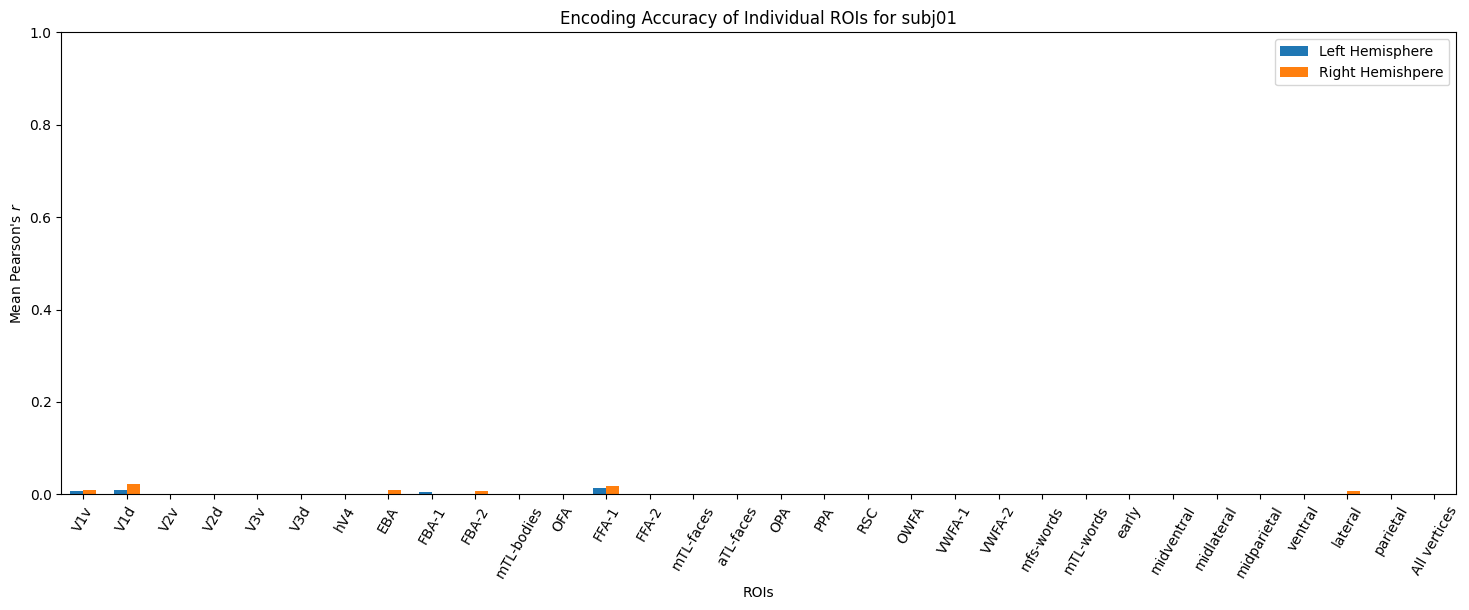

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20544/20544 [00:09<00:00, 2118.32it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


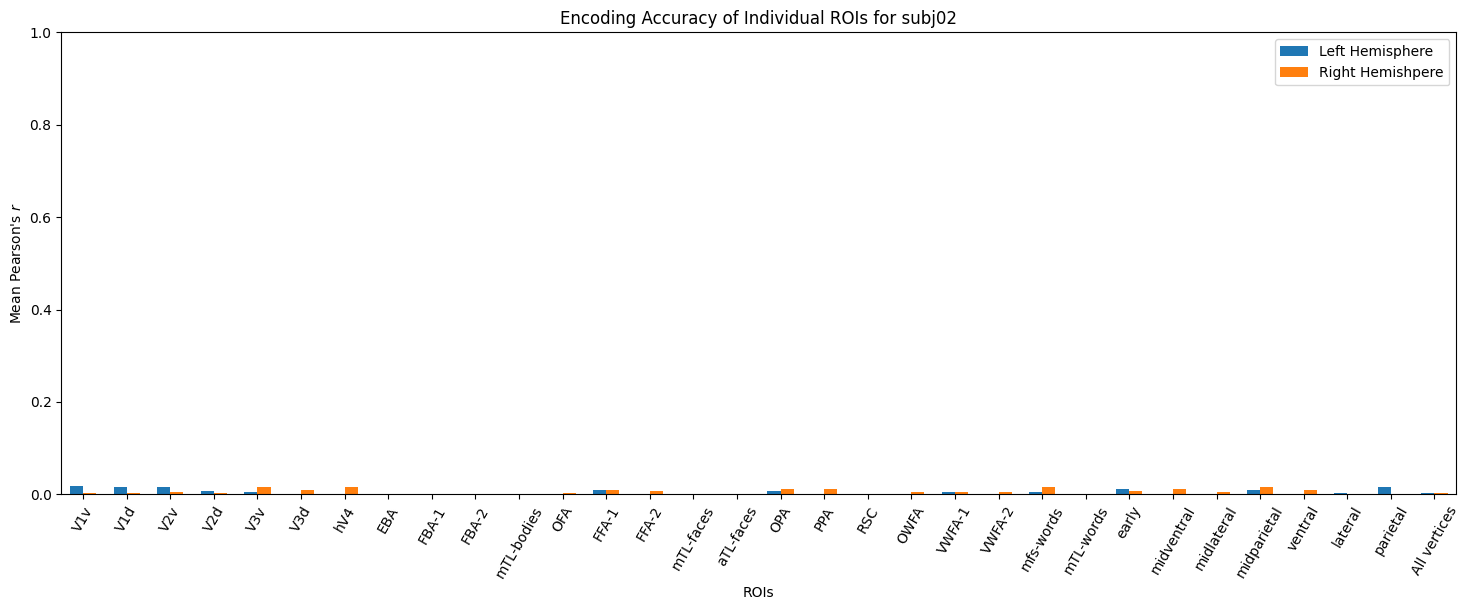

Shape of pca_brain:  (908, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20544/20544 [00:09<00:00, 2183.21it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


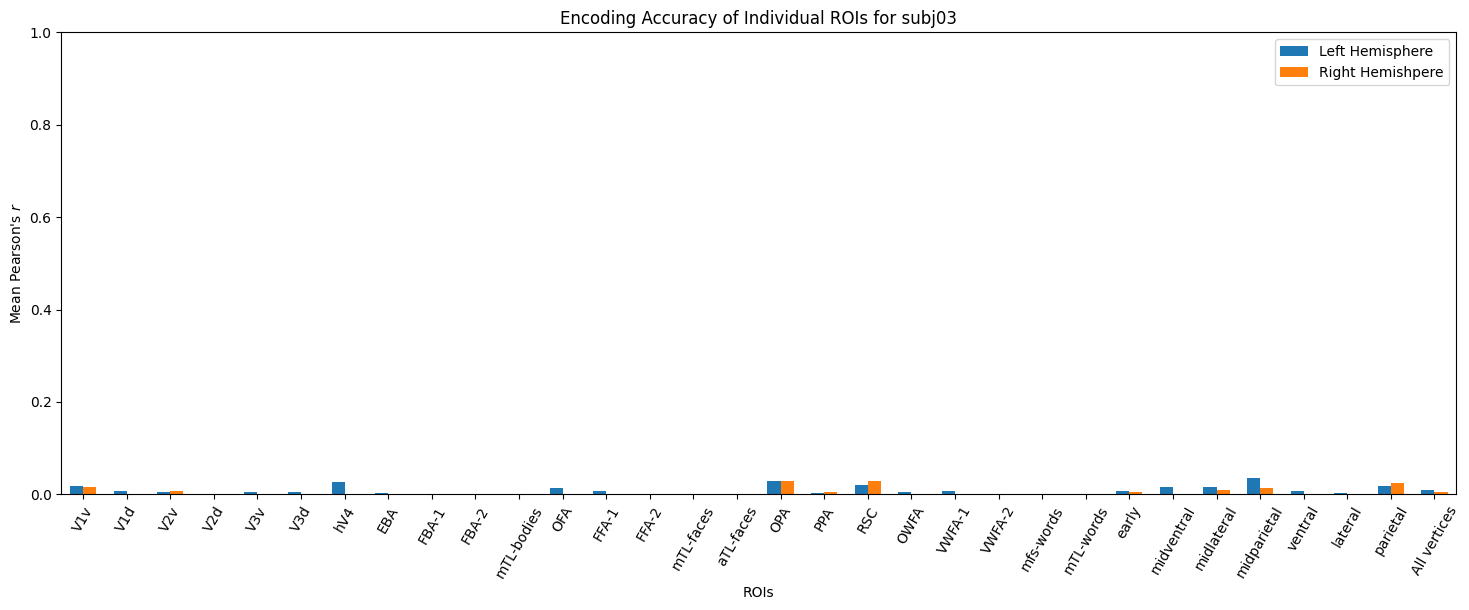

Shape of pca_brain:  (877, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20544/20544 [00:09<00:00, 2130.46it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


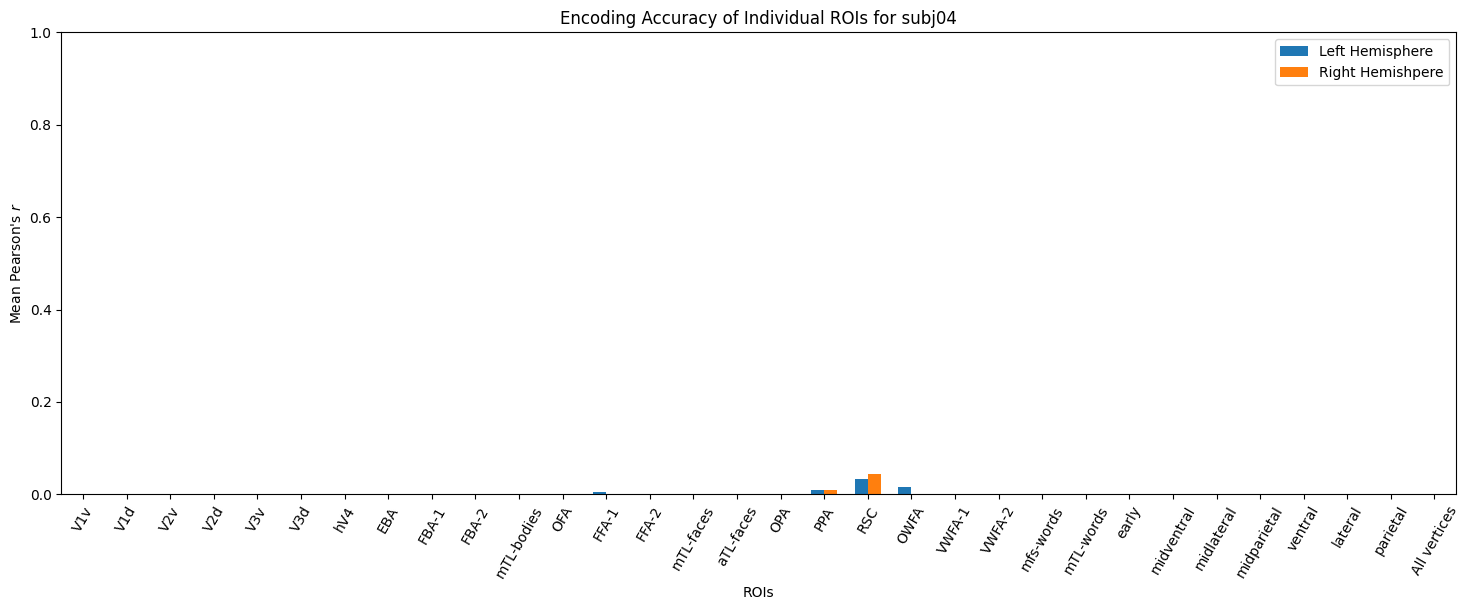

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20544/20544 [00:10<00:00, 2043.73it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


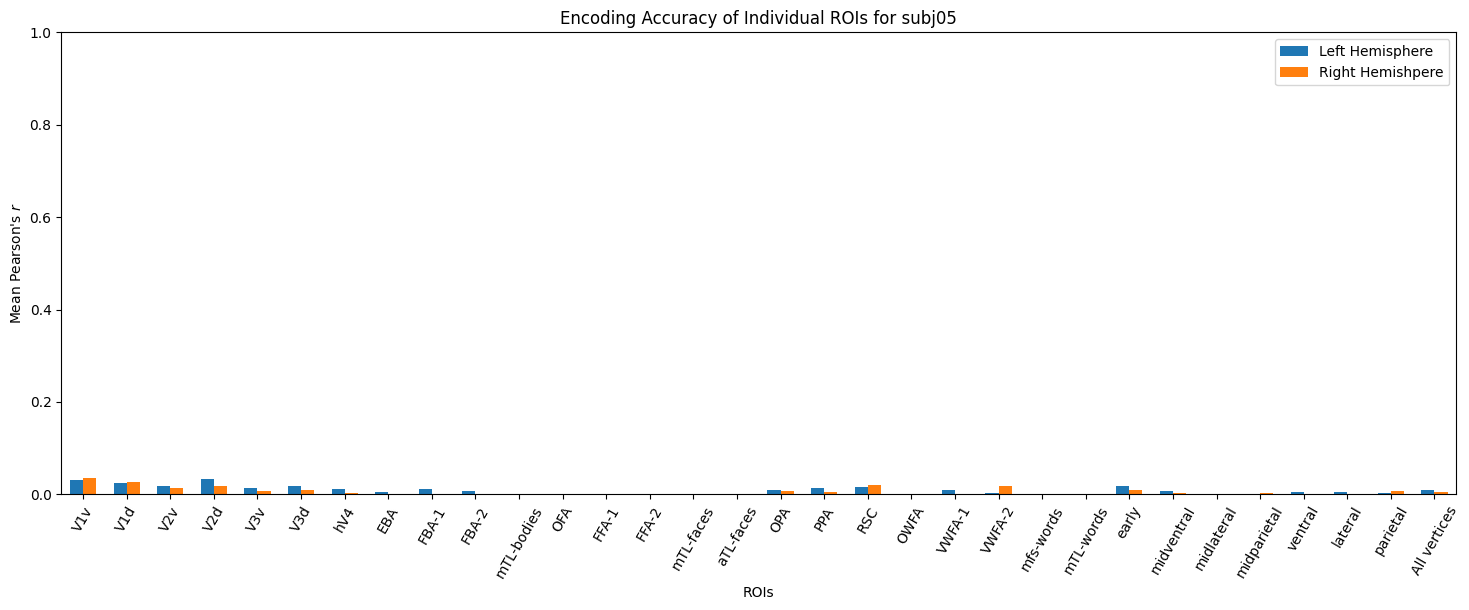

Shape of pca_brain:  (908, 39198)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20220/20220 [00:10<00:00, 1903.50it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


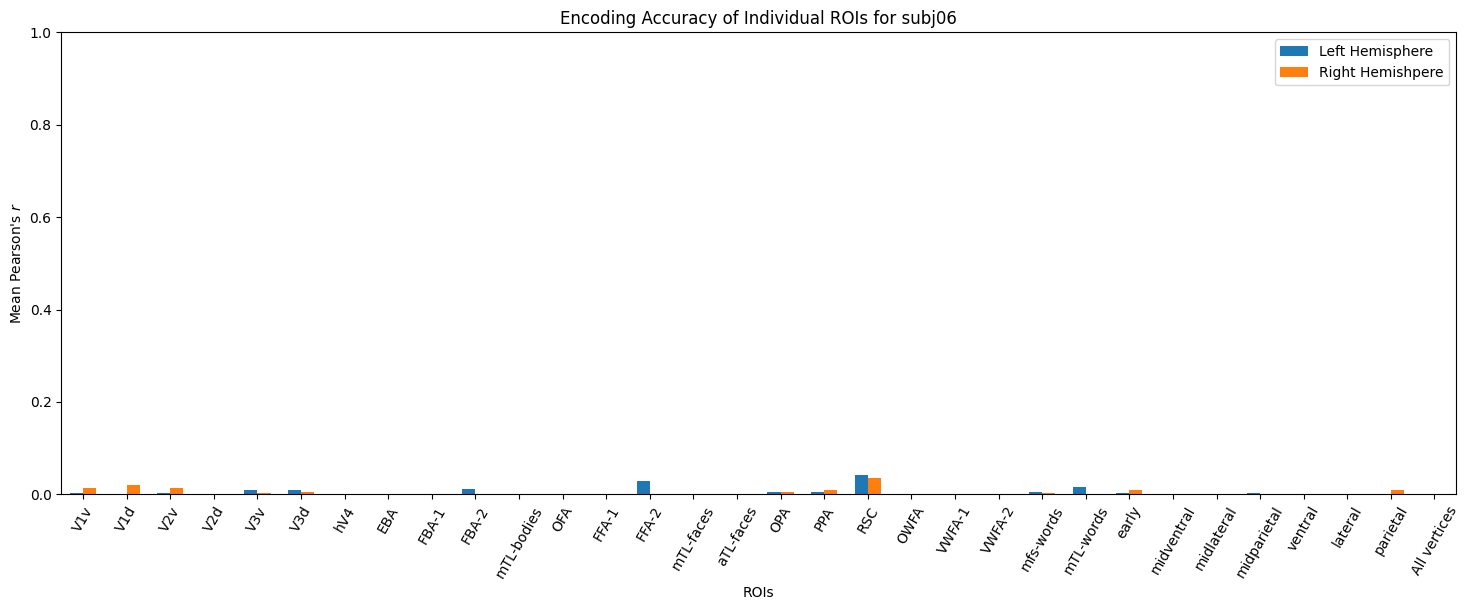

Shape of pca_brain:  (984, 39548)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20544/20544 [00:09<00:00, 2063.50it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


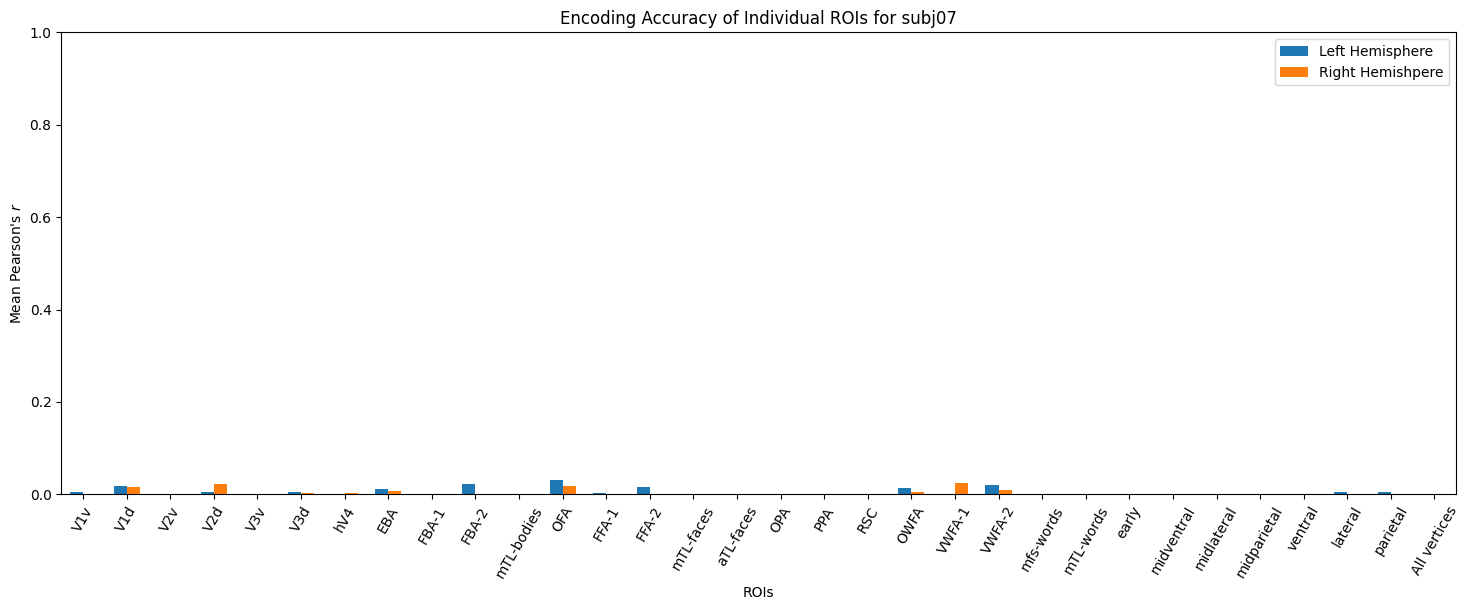

Shape of pca_brain:  (877, 39511)


/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 20530/20530 [00:15<00:00, 1352.90it/s]
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emilykruger/Documents/GitHub/aml_project_2023/aml_project_2023/aml_venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


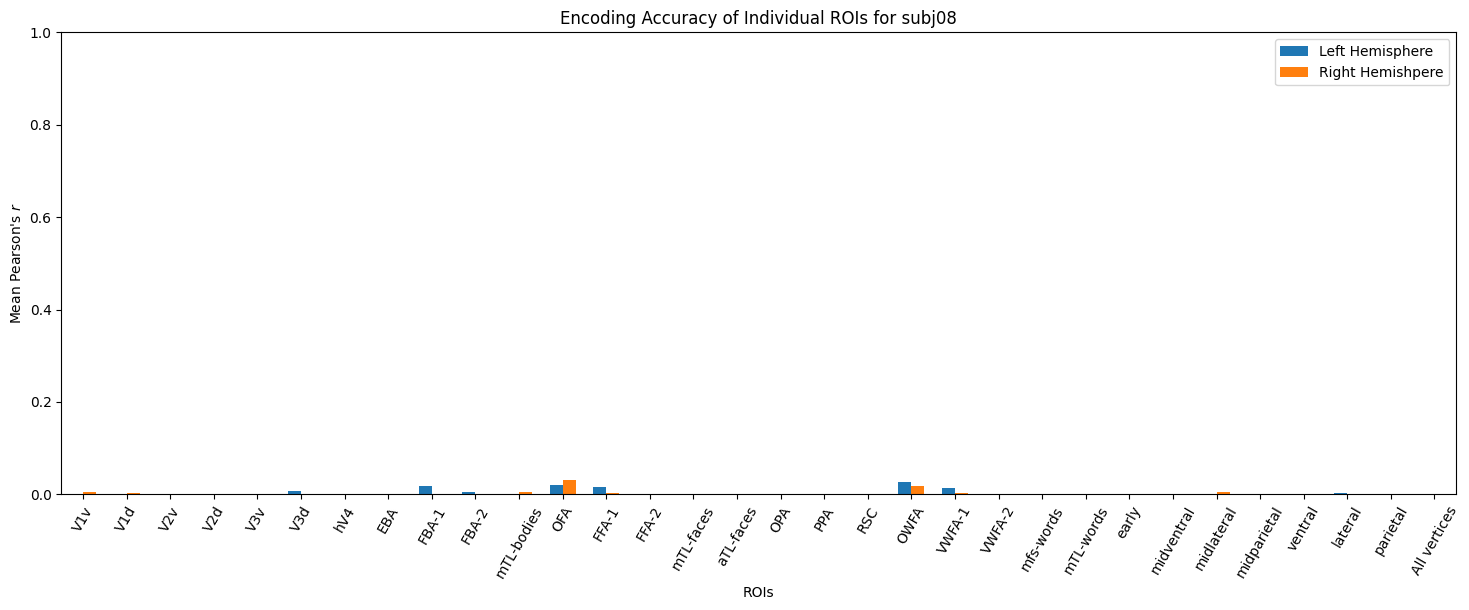

final MNNPC score:  tensor(0.5032)


In [3]:
for subject_id in list(range(1,8+1)):
    #load images and original activations 
    brain, image_paths = load_subject_data(subject_id)

    #pick image and activation
    images = []
    for i in range(len(image_paths)):
        image = np.load(image_paths[i])
        image = preprocess(image)
        images.append(image)
    activation = torch.Tensor(brain)

    output_size = 100

    # Check if GPU is available and if not, use CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Load in model & Create feature extractor
    trained_model_state_dict = torch.load(checkpoint_path, map_location = device)
    feature_extractor = torch.hub.load('utils', backbone, source = 'local')

    trained_model = ResNet1HeadID(output_size = output_size, feature_extractor= feature_extractor, simple_head=simple_head_state).eval()
    trained_model.load_state_dict(trained_model_state_dict["model_state_dict"])
    trained_model_backbone = trained_model.feature_extractor

    output_layer_names = get_module_names(trained_model_backbone)[1:-1]

    feature_extractor = create_feature_extractor(trained_model_backbone, output_layer_names)

    #Extract features & predict fMRI data 
    outputs = feature_extractor(image.unsqueeze(0))
    flat_outputs = flatten_features(outputs)
    predictions = make_prediction(trained_model, flat_outputs, trained_model.head.in_features)
    print(predictions)

    #Inverse transform of preds with frozen PCA models
    pca = get_pca_model(subject_id)
    inversed_predictions = predictions.copy()
    for key in inversed_predictions:
        #convert prediction tensors to np arrays to make it compatible for inverse pca
        preds = inversed_predictions[key].detach().numpy()
        preds = torch.Tensor(pca.inverse_transform(preds))
        # inverse-pca and store in new dict
        inversed_predictions[key] = preds

    #use loaded model from beginning and pass image through
    preds = np.zeros(activation.shape)
    for i, img in enumerate(images):
        pred = trained_model(img.unsqueeze(0))
        inversed_pred = pca.inverse_transform(pred.detach().numpy()).flatten()
        preds[i,:] = inversed_pred

    predictions = torch.Tensor(preds)

    #calculate MNNPC score
    mnnpc = MNNPC()
    score = mnnpc(pred = predictions, gt=activation)

    corr_roi_plot(gt_activation=activation, pred_activation=predictions, subject=subject_id)


print('final MNNPC score: ', score)  